**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np

For the implementation of CNN, we have used keras library on top of tensor flow.

In [2]:
import keras

**Image Preprocessing**

Loading the images converting them to array and rotating the images and appending them to the same array so as to bring uniformity in the data, i.e. trying to eliminate the problem of different orientations etc.


1.0


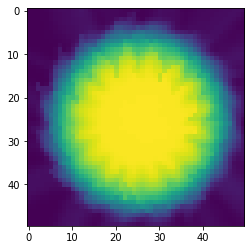

In [3]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
path = "code/images/"
images_arr = []


for i in range(1584):
    img_path = path + str(i+1) + '.jpg'
    
    img = image.load_img(img_path, color_mode='grayscale', target_size=(50,50))
    img_arr = image.img_to_array(img)
    tmp = np.zeros(img_arr.shape)
    tmp += img_arr
    theta = 22.5
    while theta < 360:
        img_arr = image.apply_affine_transform(img_arr, theta=theta)
        tmp += img_arr
        theta += 22.5
    tmp = tmp.astype('float32')
    tmp /= (360/22.5)
    images_arr.append(tmp/255)
    
plt.imshow(image.array_to_img(images_arr[8]))
print(images_arr[8].max())

**Numbering the species name**

Reading the csv file using pandas framework and assigning unique ids to the names of the species. The dataset consists of 64 x 3 features , along with the species name, id (corresponding to the image) and index

In [4]:
data = pd.read_csv('./train.csv')
print(data.head())
idx = 0
name2id = {}
for sp in data.species:
    if sp not in name2id:
        name2id[sp] = idx
        idx += 1

print(len(name2id))

   id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883  

real_data array consists of the features of the dataset

real_label array consists of the label of the species

real_id consists of the id of the image

Now everything is combined to form one single array of x_train and y_train for training purposes

x_train_img consists of image training data (3-d array of images)

x_train consists of 64x3 features read from the csv file

y_train consists of correct output for the image

Also converting the y_train and y_test to one hot encoded form for softmax_loss calculation purposes

In [5]:
head = []
head += ['margin'+str(i+1) for i in range(64)]
head += ['shape'+str(i+1) for i in range(64)]
head += ['texture'+str(i+1) for i in range(64)]


real_data = [[] for i in range(990)]
real_label = []
real_id = []
for i in data.id:
    real_id.append(i)
for h in head:
    for i , val in enumerate(data[h]):
        real_data[i].append(val)

for label in data.species:
    real_label.append(name2id[label])

assert(len(real_data) == len(real_label))

**Splitting into train and test data set**

In [6]:
x_train, y_train, x_test, y_test = [], [], [], []
x_train_img, x_test_img = [], []

for i in range(len(real_data)):
    if i % 5 == 0:
        x_test_img.append(images_arr[ real_id[i] - 1 ])
        x_test.append(real_data[i])
        y_test.append(real_label[i])
        continue
    x_train.append(real_data[i])
    x_train_img.append(images_arr[ real_id[i] - 1 ])
    y_train.append(real_label[i])

x_train = np.array(x_train)
x_train_img = np.array(x_train_img)
x_test = np.array(x_test)
x_test_img = np.array(x_test_img)
y_test = np.array(y_test)
y_train = np.array(y_train)

from keras.utils import to_categorical

y_train = to_categorical(y_train).astype('float32')
y_test = to_categorical(y_test).astype('float32')

**Printing the shape of the train and test dataset**

In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(792, 192)
(198, 192)
(198, 99)
(792, 99)


**Defining the Neural Network**

The neural network architecture consists of two sets of layers, first the set of convolution layers and maxpooling layers which we have concatenated with the input feature layers and connected further to dense layers. Then we applied the convolution layer model

In [8]:
input_dim = len(x_train[0])
print(input_dim)



from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate

inp_img = Input(shape=(50,50,1), name='input_img')
c1 = Conv2D(16, kernel_size=3, activation='relu')(inp_img) # 48 x 48
p1 = MaxPooling2D(pool_size=(2,1))(c1) # 24 x 48
p1 = MaxPooling2D(pool_size=(1,2))(p1) # 24 x 24
c2 = Conv2D(32, kernel_size=3, activation='relu')(p1) # 22 x 22
p2 = MaxPooling2D(pool_size=(2,1))(c2) # 11 x 22
p2 = MaxPooling2D(pool_size=(1,2))(p2) # 11 x 11
c3 = Conv2D(32, kernel_size=3, activation='relu')(p2) # 9 x 9
f1 = Flatten()(c3) # 64 x 9 x 9 x 16

inp_feat = Input(shape=(input_dim, ), name='input_feat')
x = concatenate([inp_feat, f1])
d = Dense(1500, activation='relu')(x)
d = BatchNormalization()(d)
d = Dense(1000, activation='relu')(d)
d = BatchNormalization()(d)
d = Dense(500, activation='relu')(d)
d = BatchNormalization()(d)
d = Dense(115, activation='relu')(d)
d = BatchNormalization()(d)
out = Dense(99, activation='softmax', name='output')(d)

model = Model(inputs=[inp_img, inp_feat], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

192
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 50, 50, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 16)   160         input_img[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 24, 48, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 24, 24, 16)   0           max_pooling2d[0][0]              
___________________________________________________________________________________

**Model Fitting**

In [9]:
model.fit( {  'input_img' : x_train_img, 'input_feat'  : x_train}, 
              y_train, epochs = 60, batch_size=50, verbose = 1, 
              validation_data=({'input_img':x_test_img,
              'input_feat':x_test}, y_test))


Epoch 1/60
16/16 [==============================] - 1s 76ms/step - loss: 4.0216 - accuracy: 0.1313 - val_loss: 4.6602 - val_accuracy: 0.0000e+00
Epoch 2/60
16/16 [==============================] - 1s 67ms/step - loss: 2.4514 - accuracy: 0.4672 - val_loss: 4.5937 - val_accuracy: 0.0202
Epoch 3/60
16/16 [==============================] - 1s 69ms/step - loss: 1.2697 - accuracy: 0.8169 - val_loss: 4.6271 - val_accuracy: 0.0202
Epoch 4/60
16/16 [==============================] - 1s 75ms/step - loss: 0.6086 - accuracy: 0.9343 - val_loss: 4.6404 - val_accuracy: 0.0202
Epoch 5/60
16/16 [==============================] - 1s 79ms/step - loss: 0.3047 - accuracy: 0.9811 - val_loss: 4.6483 - val_accuracy: 0.0202
Epoch 6/60
16/16 [==============================] - 1s 72ms/step - loss: 0.1736 - accuracy: 0.9912 - val_loss: 4.6763 - val_accuracy: 0.0202
Epoch 7/60
16/16 [==============================] - 1s 74ms/step - loss: 0.1022 - accuracy: 0.9937 - val_loss: 4.6960 - val_accuracy: 0.0202
Epoch 8/6

**Printing the shape of model and test dataset**

In [10]:
print(x_test.shape)
inp = {'input_img' : np.array([x_test_img[0] , x_test_img[1]]), 
      'input_feat'  : np.array([x_test[0] , x_test[1] ]) }
x = model.predict(inp)
print(x.shape)

(198, 192)
(2, 99)
